In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

In [5]:
l = np.arange(-180,180,1)
b = np.arange(-90,90,1)
l_grid, b_grid = np.meshgrid(l, b)
c = SkyCoord(l=l_grid*u.degree, b=b_grid*u.degree, frame='galactic')
l_arr = l_grid.flatten()
b_arr = b_grid.flatten()

#the map is in (ra,dec) so we need to convert:
ra = c.icrs.ra.degree.flatten() 
dec = c.icrs.dec.degree.flatten() 

In [6]:
def plot_completeness(l, b, completeness, title=None):
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.scatter( l, b, c=completeness , vmin=0.8, vmax=1,s=1)
    plt.colorbar(label='completeness')
    plt.xlim(180,-180)
    plt.ylim(-90, 90)
    plt.xlabel('l (degrees)')
    plt.ylabel('b (degrees)')
    plt.show()

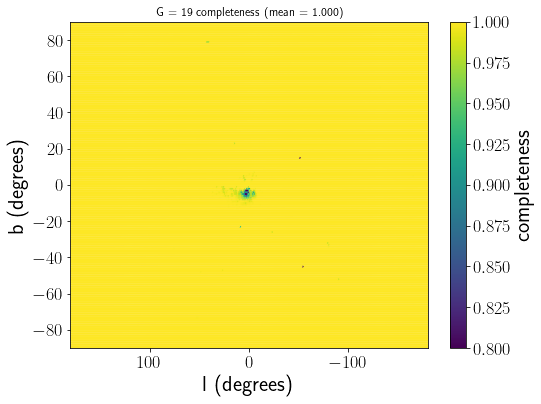

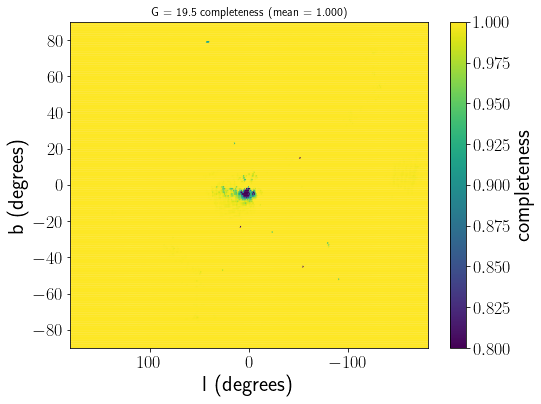

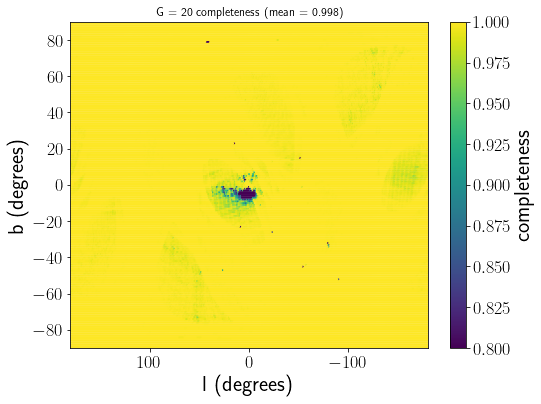

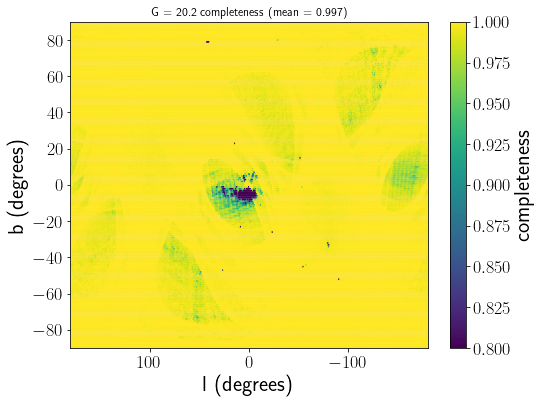

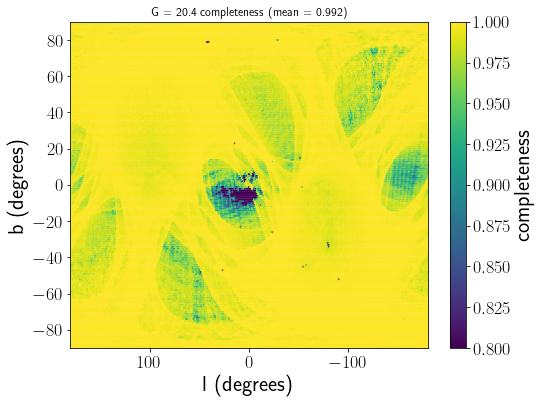

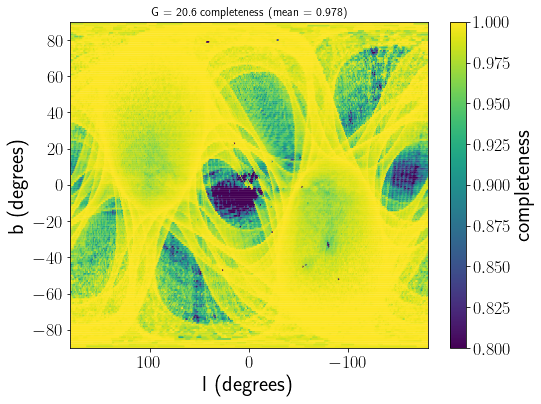

In [6]:
gmag_lims = [19, 19.5, 20, 20.2, 20.4, 20.6]
for gmag in gmag_lims:
    completeness = utils.get_completeness(ra, dec, gmag)
    title = f'G = {gmag} completeness (mean = {np.mean(completeness):.3f})'
    plot_completeness(l_arr, b_arr, completeness, title=title)

Uniform random on sphere (idk if l and b are uniform?? maybe not?)

In [7]:
N_sphere = int(1e6)
ra_sphere, dec_sphere = utils.random_ra_dec_on_sphere(rng, N_sphere)

NPIX: 49152


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


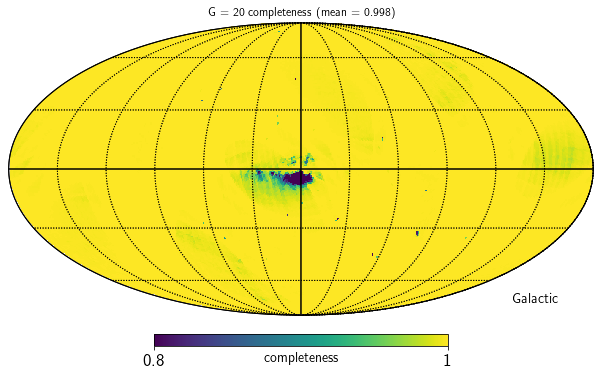

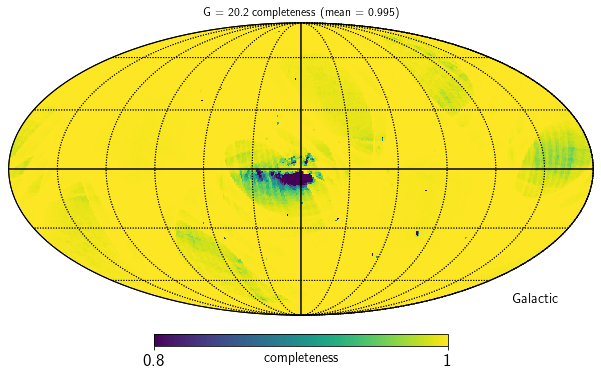

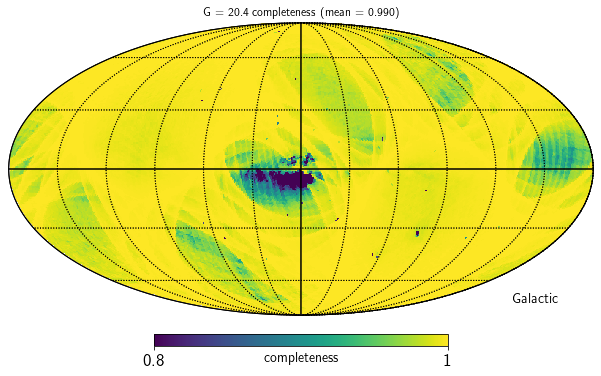

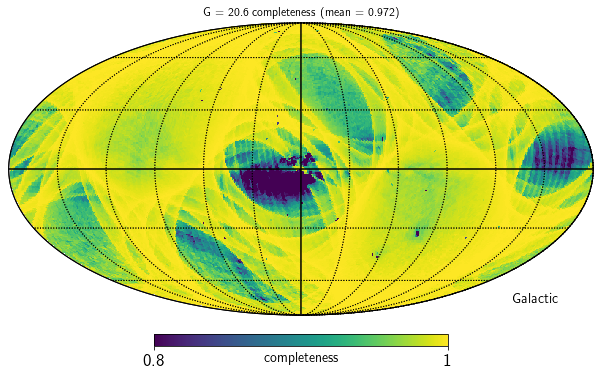

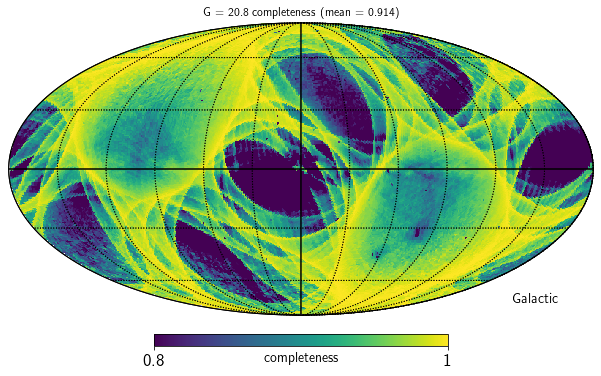

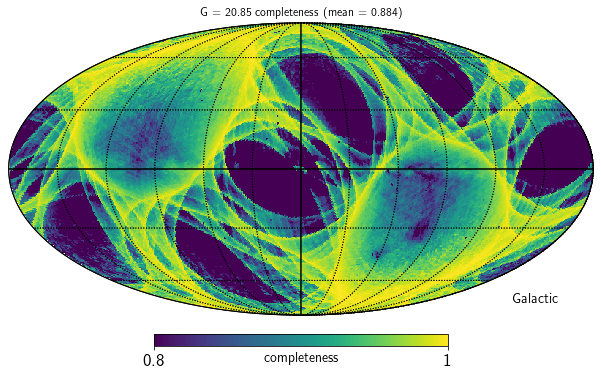

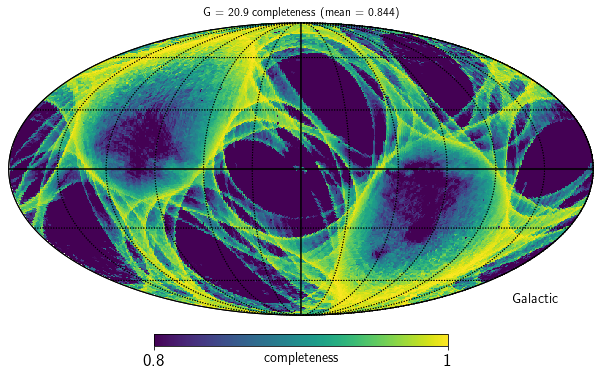

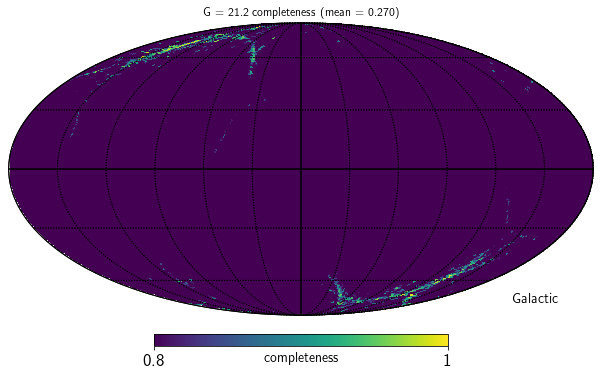

In [8]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(f"NPIX: {NPIX}")
gmag_lims = [20, 20.2, 20.4, 20.6, 20.8, 20.85, 20.9, 21.2]
for gmag in gmag_lims:
    gmags = np.full(len(ra_sphere), gmag)
    completeness = utils.get_completeness(ra_sphere, dec_sphere, gmags)
    title = f'G = {gmag} completeness (mean = {np.mean(completeness):.3f})'
    map_comp, _ = utils.get_map(64, ra_sphere, dec_sphere, quantity=completeness, func_name='mean',
            null_val=np.nan)

    hp.mollview(map_comp, title=title, unit=r"completeness",
                cmap='viridis', coord=['C', 'G'], min=0.8, max=1)
    hp.graticule()
    #I = np.random.uniform(size=len(ra_sphere)) < completeness
    #map_n, _ = utils.get_map(64, ra_sphere[I], dec_sphere[I], func_name='count',
    #        null_val=0)
    #hp.mollview(map_n, title=title, unit=r"completeness",
    #            cmap='viridis', coord=['C', 'G'])#, min=0, max=1)
    hp.graticule()

# Gmag lim comparison

In [4]:
NSIDE = 64
G_maxs = [20, 20.2, 20.4]

Number of data sources: 648842
Number of data sources: 812375
Number of data sources: 1001557


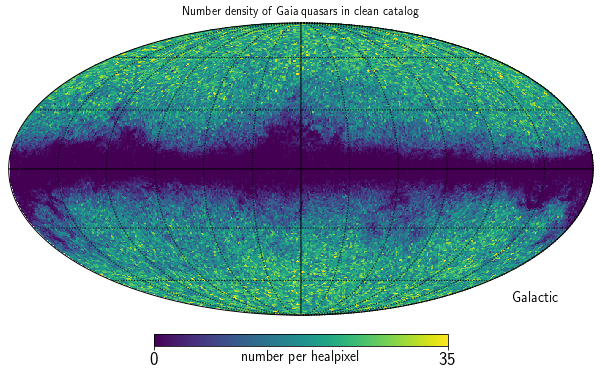

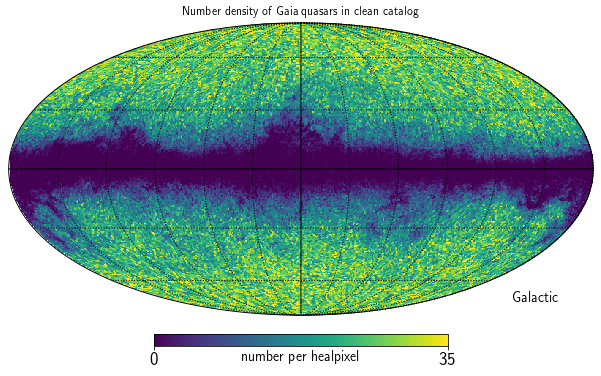

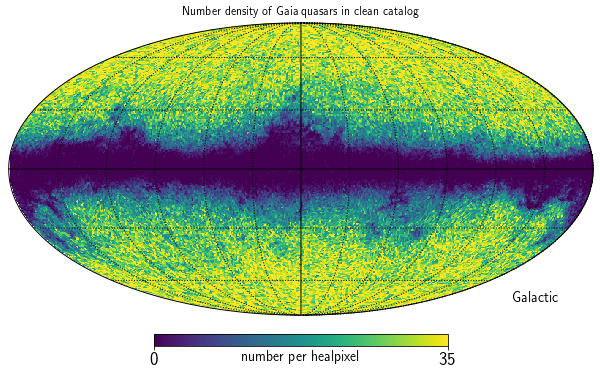

In [7]:
for G_max in G_maxs:
    fn_gaia_G = f'../data/gaia_G{G_max}.fits'
    tab_gaia_G = utils.load_table(fn_gaia_G)
    N_data_G = len(tab_gaia_G)
    print(f"Number of data sources: {N_data_G}")
    
    map_nqso_data_G, pixel_indices_data_G = utils.get_map(NSIDE, tab_gaia_G['ra'], tab_gaia_G['dec'], null_val=0)
    
    hp.mollview(map_nqso_data_G, title=rf"Number density of Gaia quasars in clean catalog",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=35)
    hp.graticule()

## Load in data

In [6]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [7]:
fn_gaia = '../data/gaia_spz_kNN.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [8]:
map_nqso_data, pixel_indices_data = utils.get_map(NSIDE, ra_data, dec_data, null_val=0)

0.0 180.0 -180.0 180.0


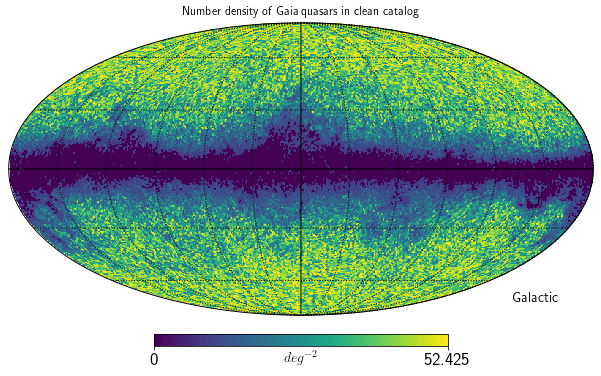

In [9]:
hp.mollview(map_nqso_data/area_per_pixel, title=rf"Number density of Gaia quasars in clean catalog",
            unit=r"$deg^{-2}$", cmap='viridis', coord=['C', 'G'], min=0, max=10)
hp.graticule()

## m10 healpix map

In [10]:
map_m10 = utils.get_m10_map(NSIDE)

Generating new dust map (None
NPIX for dust map sampling: 50331648


0.0 180.0 -180.0 180.0


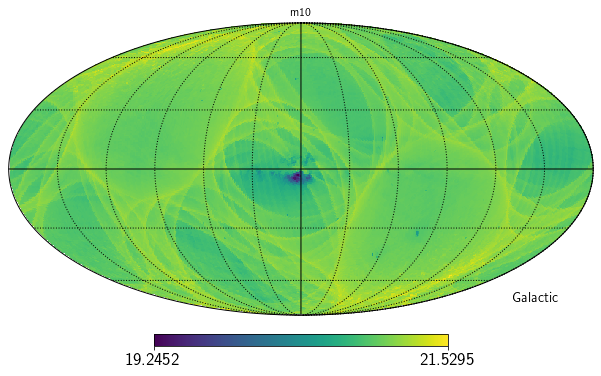

In [12]:
hp.mollview(map_m10, title=rf"m10",
            unit=r"", cmap='viridis', coord=['C', 'G'])
hp.graticule()

## Fit m10 vs number density

In [26]:
bins_m10 = np.linspace(np.min(map_m10), np.max(map_m10), 40)
bins_nqso = np.arange(0, np.ceil(np.max(map_nqso_data)), 1)

Text(0, 0.5, 'number of Gaia QSOs')

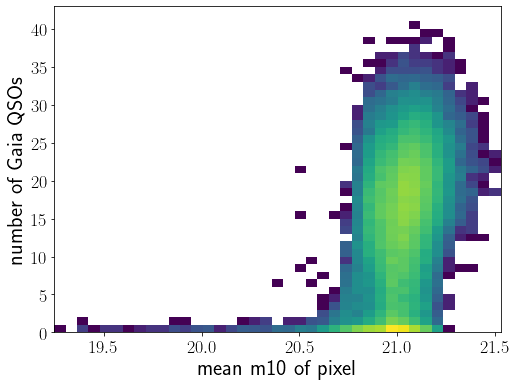

In [30]:
map_nqso_data

plt.figure(figsize=(8,6))

plt.hist2d(map_m10, map_nqso_data, bins=[bins_m10, bins_nqso], norm=matplotlib.colors.LogNorm(), )
#plt.plot(map_av_rand[idx_av_sorted], p_Av[idx_av_sorted], color='orange', lw=3, label='Best fit exponential')

#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0, 3)
plt.xlabel(r'mean m10 of pixel')
plt.ylabel('number of Gaia QSOs per healpix pixel')

Text(0, 0.5, 'number of Gaia QSOs per healpix pixel')

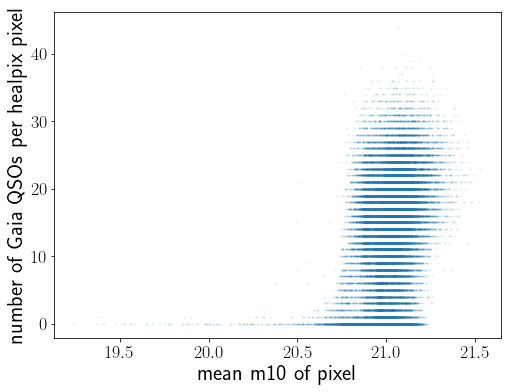

In [47]:
map_nqso_data

plt.figure(figsize=(8,6))

plt.scatter(map_m10, map_nqso_data, alpha=0.1, s=1)

#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0, 3)
plt.xlabel(r'mean m10 of pixel')
plt.ylabel('number of Gaia QSOs per healpix pixel')

## Show dust as additional dimension

In [69]:
fn_dustmap = f'../data/dustmap_Avmean_NSIDE{NSIDE}.npy'
map_avmean = utils.get_dust_map(None, None, fn_dustmap=fn_dustmap)

Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy


(0.0, 50.0)

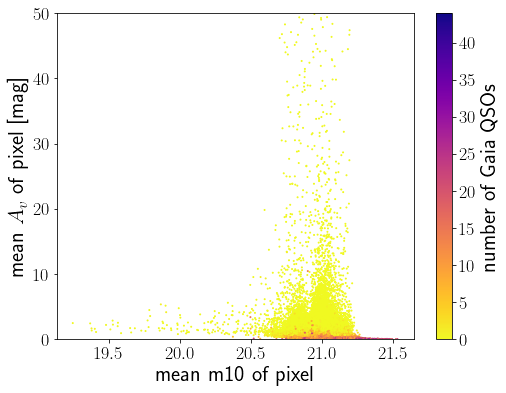

In [44]:
plt.figure(figsize=(8,6))

plt.scatter(map_m10, map_avmean, c=map_nqso_data, cmap='plasma_r', s=1, vmin=0)
plt.colorbar(label='number of Gaia QSOs')

plt.xlabel('mean m10 of pixel')
plt.ylabel(r'mean $A_v$ of pixel [mag]')

plt.ylim(0, 50)

(0.0, 1.0)

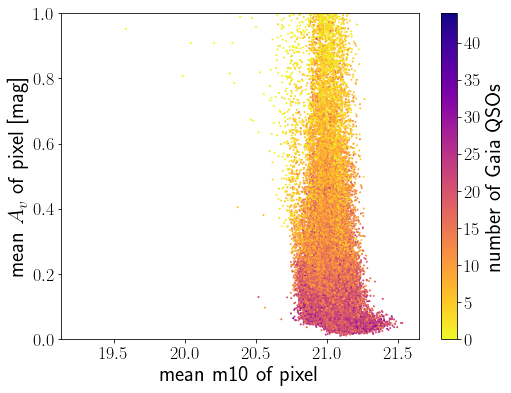

In [42]:
plt.figure(figsize=(8,6))

plt.scatter(map_m10, map_avmean, c=map_nqso_data, cmap='plasma_r', s=1, vmin=0)
plt.colorbar(label='number of Gaia QSOs')

plt.xlabel('mean m10 of pixel')
plt.ylabel(r'mean $A_v$ of pixel [mag]')
plt.ylim(0, 1)

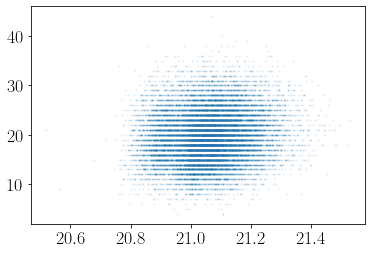

In [49]:
idx_lowext = map_avmean < 0.2
plt.scatter(map_m10[idx_lowext], map_nqso_data[idx_lowext], s=1, alpha=0.1)


(20.5, 21.5)

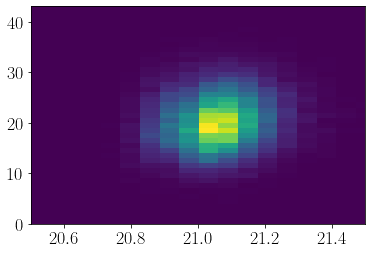

In [54]:
idx_lowext = map_avmean < 0.2
plt.hist2d(map_m10[idx_lowext], map_nqso_data[idx_lowext], bins=[bins_m10, bins_nqso])
plt.xlim(20.5, 21.5)

# Stellar density

In [70]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(area_per_pixel)
map_stars = utils.get_star_map(NSIDE)
map_stardens = map_stars/area_per_pixel

0.8392936452111668
Generating new dust map (None)


FileNotFoundError: [Errno 2] No such file or directory: '../data/stars_gaia_G18.5-20.0_rand3e7.fits.gz'

0.0 180.0 -180.0 180.0


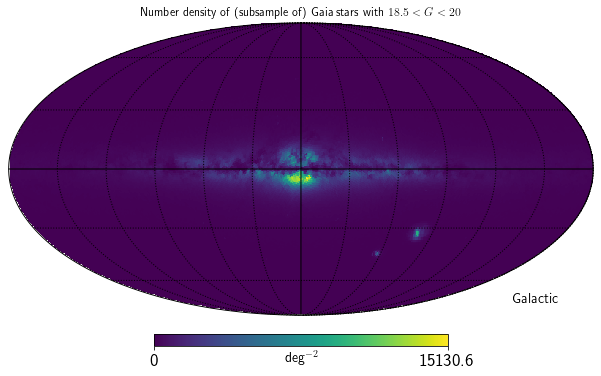

In [148]:
hp.mollview(map_stardens, title=rf"Number density of (subsample of) Gaia stars with $18.5<G<20$",
            unit=r"deg$^{-2}$", cmap='viridis', coord=['C', 'G'], min=0)
hp.graticule()

0.0 180.0 -180.0 180.0


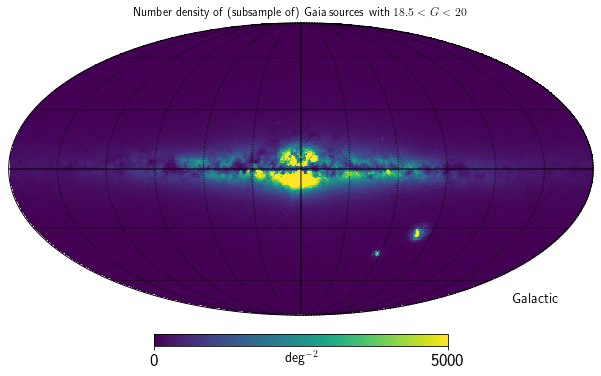

In [149]:
hp.mollview(map_stardens, title=rf"Number density of (subsample of) Gaia sources with $18.5<G<20$",
            unit=r"deg$^{-2}$", cmap='viridis', coord=['C', 'G'], min=0, max=5000)
hp.graticule()

In [150]:
stardens_max = 1000
bins_stardens = np.linspace(np.min(map_stardens), stardens_max, 50)

Text(0.5, 0, 'stellar density of healpix pixel [deg$^{-2}$]')

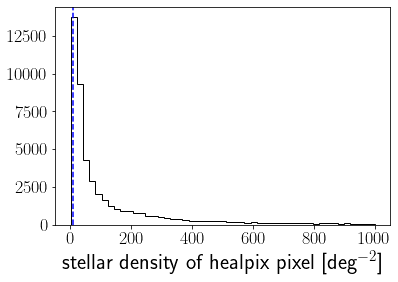

In [152]:
av_bins = np.linspace(0, 1, 50)
plt.hist(map_stardens, bins=bins_stardens, histtype='step', color='k')
stardens0_max = 10
plt.axvline(stardens0_max, color='b', ls='--')
plt.xlabel(r'stellar density of healpix pixel [deg$^{-2}$]')

I think this is exactly the same as the Av case?

Text(0, 0.5, 'number of Gaia QSOs in healpix pixel')

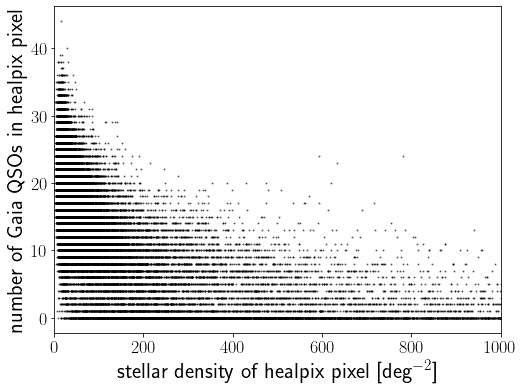

In [153]:
plt.figure(figsize=(8,6))

plt.scatter(map_stardens, map_nqso_data, c='k', s=1, alpha=0.5)
plt.xlim(0, stars_max)
plt.xlabel(r'stellar density of healpix pixel [deg$^{-2}$]')
plt.ylabel('number of Gaia QSOs in healpix pixel')

Text(0, 0.5, 'number of Gaia QSOs per healpix pixel')

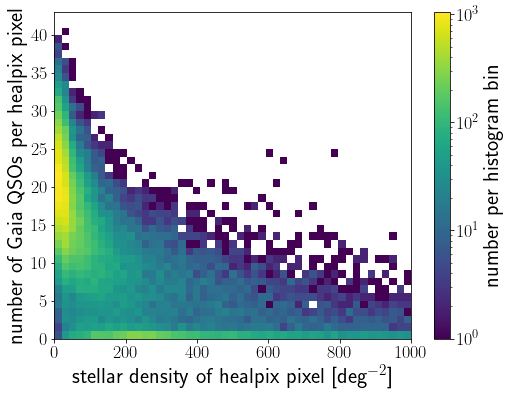

In [154]:
plt.figure(figsize=(8,6))

stars_max = 1000
plt.hist2d(map_stardens, map_nqso_data, bins=[bins_stars, bins_nqso], norm=matplotlib.colors.LogNorm(), )
plt.colorbar(label='number per histogram bin')
#plt.plot(map_av_rand[idx_av_sorted], p_Av[idx_av_sorted], color='orange', lw=3, label='Best fit exponential')

plt.xlim(0, stars_max)
plt.xlabel(r'stellar density of healpix pixel [deg$^{-2}$]')
plt.ylabel('number of Gaia QSOs per healpix pixel')

Text(0, 0.5, 'mean $A_v$ of healpix pixel [mag]')

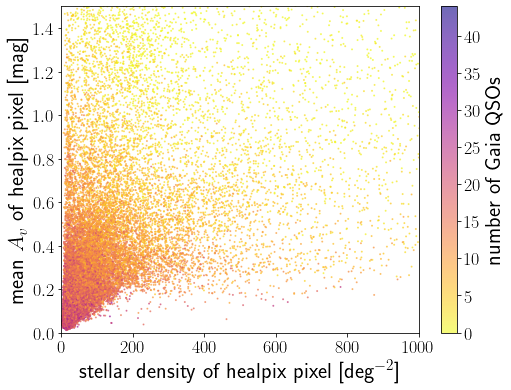

In [155]:
plt.figure(figsize=(8,6))

plt.scatter(map_stardens, map_avmean, c=map_nqso_data, cmap='plasma_r', s=1, vmin=0, alpha=0.6)
plt.colorbar(label='number of Gaia QSOs')

plt.xlim(0, 1000)
plt.ylim(0, 1.5)
plt.xlabel(r'stellar density of healpix pixel [deg$^{-2}$]')
plt.ylabel(r'mean $A_v$ of healpix pixel [mag]')

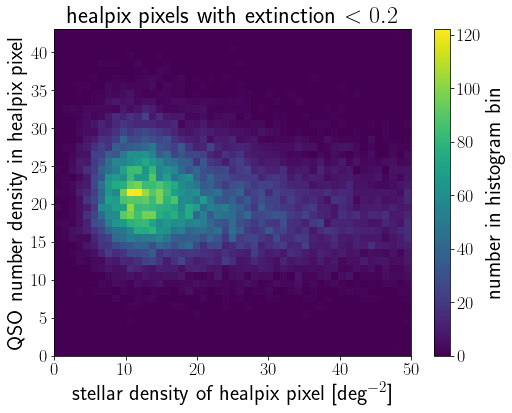

In [156]:
av_max = 0.2
idx_lowext = map_avmean < av_max
bins_stars_lowext = np.linspace(0, 50, 50)

plt.figure(figsize=(8,6))
plt.title(fr'healpix pixels with extinction $< {av_max}$', fontsize=24)
plt.hist2d(map_stars[idx_lowext], map_nqso_data[idx_lowext], bins=[bins_stars_lowext, bins_nqso])
#plt.xlim(20.5, 21.5)
plt.xlabel(r'stellar density of healpix pixel [deg$^{-2}$]')
plt.ylabel('QSO number density in healpix pixel')
plt.colorbar(label='number in histogram bin')

Now divide by the QSO density where there are few stars:

In [157]:
map_nqso_dens = map_nqso_data/area_per_pixel
map_nqso_dens_at_stardens0 = np.mean(map_nqso_data[map_stardens < stardens0_max])

In [161]:
prob_stardens = generate_random.fit_reduction_vs_quantity(NSIDE, map_stardens, map_nqso_data, val0_max=stardens0_max)
p_stardens = prob_stardens(map_stardens)

Text(0, 0.5, 'number of Gaia QSOs per healpix pixel / \\\\ number density at stellar density $< 10$')

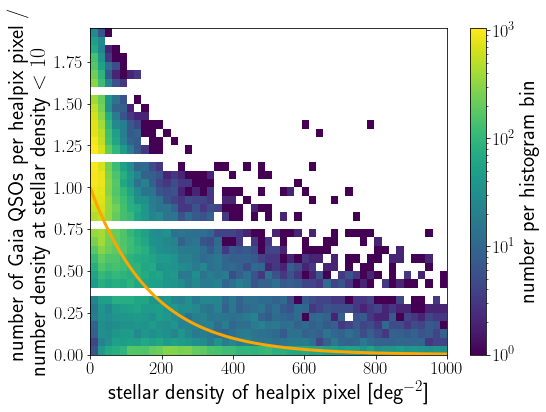

In [171]:
plt.figure(figsize=(8,6))

bins_nqso_ndens = np.arange(0, 2, 0.5/stardens0_max)
stars_max = 1000
plt.hist2d(map_stardens, map_nqso_dens/map_nqso_dens_at_stardens0, bins=[bins_stars, bins_nqso_ndens], norm=matplotlib.colors.LogNorm(), )
plt.colorbar(label='number per histogram bin')

idx_stardens_sorted = np.argsort(map_stardens)
plt.plot(map_stardens[idx_stardens_sorted], p_stardens[idx_stardens_sorted], color='orange', 
         lw=3, label='Best fit exponential')

plt.xlim(0, stars_max)
plt.xlabel(r'stellar density of healpix pixel [deg$^{-2}$]')
plt.ylabel(rf'number of Gaia QSOs per healpix pixel / \\ number density at stellar density $< {stardens0_max}$')

# M10

In [11]:
import h5py

In [57]:
fn_comp='../data/completeness_allsky_m10_hpx7.h5'
dfm10 = h5py.File(fn_comp, "r")
#map_m10 = hp.read_map(fn_comp)

In [58]:
dfm10['data'].keys()

<KeysViewHDF5 ['_i_table', 'table']>

In [59]:
map_m10_orig = np.array([bar for foo, bar in dfm10['data']['table']])
print(map_m10_orig.shape)

(196608,)


In [61]:
NSIDE = 64
map_m10 = hp.ud_grade(map_m10_orig, NSIDE, order_in='NESTED', order_out='RING')

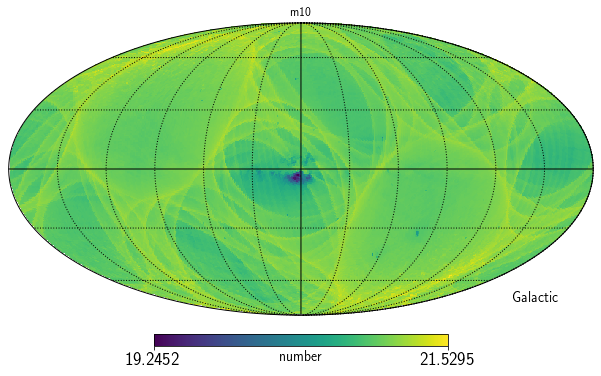

In [62]:
hp.mollview(map_m10, title=rf"m10",
            unit=r"number", cmap='viridis', nest=False, coord=['C', 'G'])#, min=0, max=5000)
hp.graticule()

# Fit model of both dust and stellar density

Make design matrix: rows are healpixels, columns are: 

constant, f(dust), f(stardens)

Try f just the mean value 

In [64]:
NPIX = hp.nside2npix(NSIDE)
print(NSIDE, NPIX)

64 49152


In [65]:
def f_dust(map_dust):
    return np.tanh(map_dust)

In [66]:
def f_stars(map_stars):
    return np.log10(map_stars)

In [67]:
def f_m10(map_m10):
    return map_m10 - 20

In [68]:
feature_names = ['constant', r'$f$(extinction)', r'$f$(stellar density)', r'$f$(m10)']
constant = np.ones(NPIX)
X = np.vstack((constant, f_dust(map_avmean), f_stars(map_stars), f_m10(map_m10))).T
#X = np.vstack((constant, f_dust(map_avmean))).T
#X = np.vstack((constant, f_stars(map_stars))).T
print(X.shape)

NameError: name 'map_avmean' is not defined

In [476]:
label_name = 'number of QSOs'
y = map_nqso_data
print(y.shape)

(49152,)


In [477]:
def scale_X(X, scale_name='minmax'):
    if scale_name=='minmax':
        mins = np.min(X[:,1:], axis=0)
        maxes = np.max(X[:,1:], axis=0)
        X[:,1:] = (X[:,1:] - mins)/(maxes-mins)
    return X

In [478]:
X = scale_X(X)
print(np.mean(X, axis=0), np.std(X, axis=0), np.min(X, axis=0), np.max(X, axis=0))

[1.         0.35126869 0.42569393] [0.         0.33036818 0.15629595] [1. 0. 0.] [1. 1. 1.]


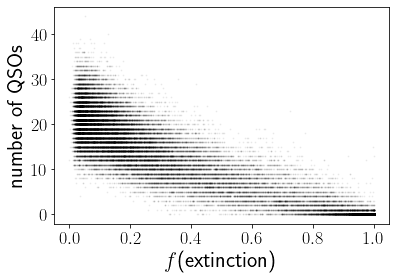

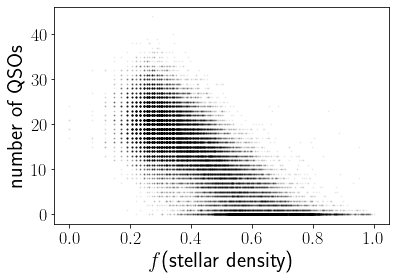

In [479]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.scatter(X[:,j], y, s=1, alpha=0.05, color='k')
    plt.xlabel(feature_names[j])
    plt.ylabel(label_name)

linear least squares: theta = (X.T * C^inv * X)^inv (X.T C^inv y)

In [480]:
# Cinv = np.identity(y.shape[0])
# print(Cinv.shape)

In [494]:
C = np.cov(X)
print(C.shape)

KeyboardInterrupt: 

In [481]:
# XTCinvX = X.T @ Cinv @ X
# XTCinvy = X.T @ Cinv @ y

In [482]:
# For now, assume C is the idensity and omit
XTCinvX = X.T @ X
XTCinvy = X.T @ y

In [483]:
print(XTCinvX.shape, XTCinvy.shape)

(3, 3) (3,)


In [484]:
res = np.linalg.lstsq(XTCinvX, XTCinvy, rcond=None)
theta = res[0]
print(theta)

[ 25.36462761 -17.44553062 -14.17881311]


In [485]:
def calc_y_pred(X, theta):
    return X @ theta

In [486]:
y_pred = calc_y_pred(X, theta)

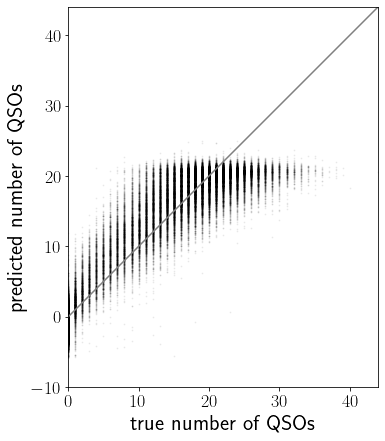

In [487]:
plt.figure(figsize=(7,7))
n_max = max(np.max(y), np.max(y_pred))
xx = np.linspace(0, n_max)
plt.plot(xx, xx, color='grey')
plt.scatter(y, y_pred, s=1, alpha=0.05, color='k')
plt.xlim(0,n_max)
plt.ylim(-10,n_max)
plt.xlabel('true '+label_name)
plt.ylabel('predicted '+label_name)
ax = plt.gca()
ax.set_aspect('equal')

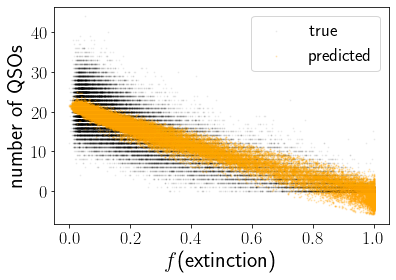

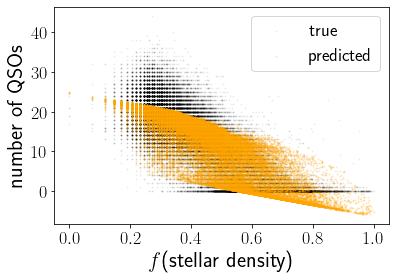

In [488]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.xlabel(feature_names[j])
    plt.ylabel(label_name)
    
    plt.scatter(X[:,j], y, s=1, alpha=0.05, color='k', label='true')
    plt.scatter(X[:,j], y_pred, color='orange', s=1, alpha=0.2, label='predicted')
    plt.legend()

0.0 180.0 -180.0 180.0


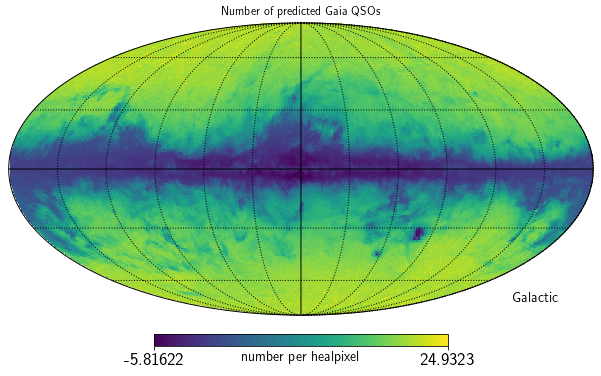

In [489]:
hp.mollview(y_pred, title=rf"Number of predicted Gaia QSOs",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'])#, min=0, max=5000)
hp.graticule()

0.0 180.0 -180.0 180.0


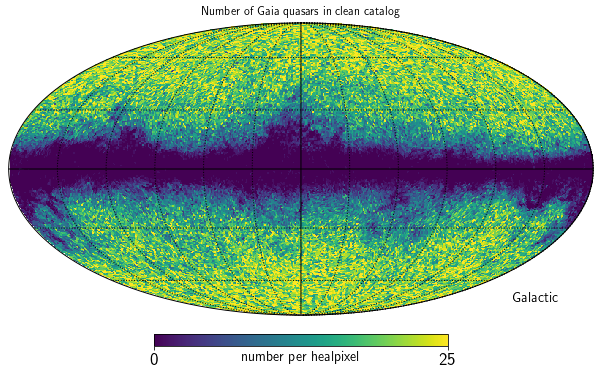

In [490]:
hp.mollview(map_nqso_data, title=rf"Number of Gaia quasars in clean catalog",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], max=25)
hp.graticule()

In [455]:
idx_clean = (map_avmean < 0.05) & (map_stars < 15)
print("Number of clean pixels:", np.sum(idx_clean))
nqso_mean_clean_regions = np.mean(map_nqso_data[idx_clean])
print(nqso_mean_clean_regions)

Number of clean pixels: 2461
21.44778545306786


Probability map should maybe be: 1 if predicted number is >= clean nmean, 0 if predicted number is <= 0, linear scale otherwise?

In [458]:
map_stardust_prob = y_pred.copy()
map_stardust_prob[map_stardust_prob>nqso_mean_clean_regions] = nqso_mean_clean_regions
map_stardust_prob[map_stardust_prob<=0] = 0
# minmax scaling but min=0 so just divide by max
map_stardust_prob = map_stardust_prob/nqso_mean_clean_regions

0.0 180.0 -180.0 180.0


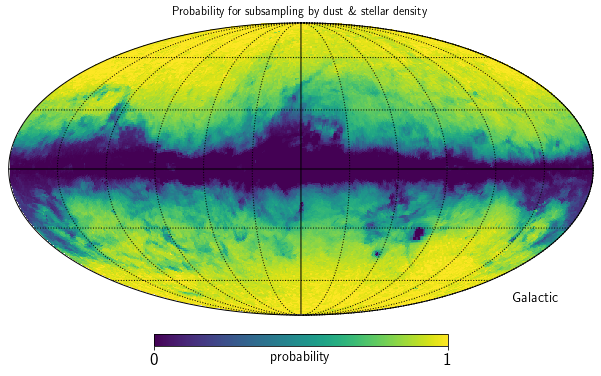

In [460]:
hp.mollview(map_stardust_prob, title=rf"Probability for subsampling by dust \& stellar density",
            unit=r"probability", cmap='viridis', coord=['C', 'G'])
hp.graticule()

In [463]:
map_stardust_prob

array([0.31065302, 0.36557535, 0.55559639, ..., 0.53367969, 0.53519373,
       0.52415142])

In [470]:
fn_map_stardust_prob = f'../data/map_dust_stars_prob_NSIDE{NSIDE}.fits'
hp.write_map(fn_map_stardust_prob, map_stardust_prob)

setting the output map dtype to [dtype('float64')]


# all map

In [71]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [72]:
fn_gaia = '../data/gaia_slim.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 6649162


In [73]:
map_nqso_data_all, pixel_indices_data_all = utils.get_map(NSIDE, ra_data, dec_data, null_val=0)

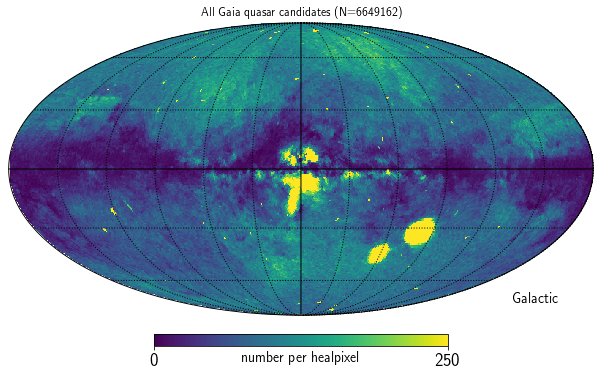

In [80]:
hp.mollview(map_nqso_data_all, title=rf"All Gaia quasar candidates (N={N_data})",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=250)
hp.graticule()

# spz

In [81]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [84]:
fn_gaia = '../data/gaia_spz_kNN.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [86]:
map_nqso_data, pixel_indices_data = utils.get_map(NSIDE, ra_data, dec_data, null_val=0)

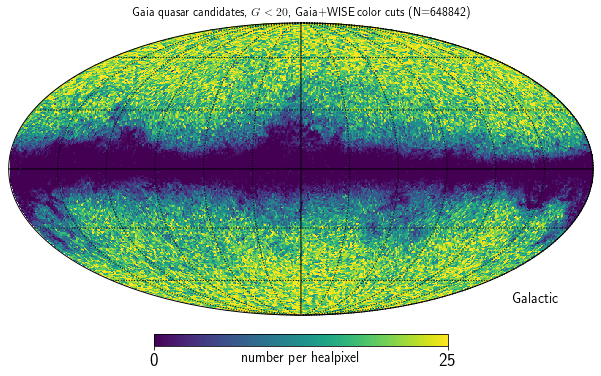

In [88]:
hp.mollview(map_nqso_data, title=rf"Gaia quasar candidates, $G<20$, Gaia+WISE color cuts (N={N_data})",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=25)
hp.graticule()